Optimizers to try
- nn.MultiLabelMarginLoss


In [1]:
import numpy as np
import pandas as pd

import torch
torch.manual_seed(1)
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset

from sklearn.model_selection import KFold
from torch.utils.data import DataLoader, SubsetRandomSampler

from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
import seaborn as sns

import time
from tqdm import tqdm

from RaceMultiOutputModel import *
from helpers import *

%load_ext autoreload
%autoreload 2

In [2]:
def visualize(losses, path=None, save=True):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.title("Training and Validation Loss")
    plt.plot(losses['training_losses'], label='Training Loss')
    plt.plot(losses['validation_losses'], label='Validation Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.title("1st Place Accuracy")
    plt.plot(losses['train_fp_acc'], label='Training Accuracy')
    plt.plot(losses['val_fp_acc'], label='Validation Accuracy')
    plt.legend()
    if save:
        plt.savefig(f'{path}Learning_Curve.png')
    else:
        plt.show()


# Model 4 version 1
- RaceMultiOutputModel4v1
- MSE Loss
- Adam

In [8]:
path = 'models/RaceMultiOutputModeltvt4v1/'

# Load data
X_train = pd.read_csv('Data/RaceMultiOutPutModeltvt/pos_1lap_X_train.csv')
y_train = pd.read_csv('Data/RaceMultiOutPutModeltvt/Y_train.csv')
X_valid = pd.read_csv('Data/RaceMultiOutPutModeltvt/pos_1lap_X_valid.csv')
y_valid = pd.read_csv('Data/RaceMultiOutPutModeltvt/Y_valid.csv')
X_test = pd.read_csv('Data/RaceMultiOutPutModeltvt/pos_1lap_X_test.csv')
y_test = pd.read_csv('Data/RaceMultiOutPutModeltvt/Y_test.csv')

X_train.drop(['raceId'],axis=1, inplace=True)
y_train.drop(['raceId'],axis=1, inplace=True)
X_valid.drop(['raceId'],axis=1, inplace=True)
y_valid.drop(['raceId'],axis=1, inplace=True)
X_test.drop(['raceId'],axis=1, inplace=True)
y_test.drop(['raceId'],axis=1, inplace=True)


# Create Dataset and DataLoader for train and test sets
train_dataset = RaceDataset(torch.tensor(X_train.values, dtype=torch.float32), torch.tensor(y_train.values, dtype=torch.float32))
valid_dataset = RaceDataset(torch.tensor(X_valid.values, dtype=torch.float32), torch.tensor(y_valid.values, dtype=torch.float32))
test_dataset = RaceDataset(torch.tensor(X_test.values, dtype=torch.float32), torch.tensor(y_test.values, dtype=torch.float32))

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)
train_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

def train_model4v1(train_loader, test_loader, epochs=10, load=False, lr=0.001, viz=False, path=None):


    if not os.path.exists(path):
        os.makedirs(path)

    model = RaceMultiOutputModel4()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    if not load:
        prev_epoch = 0
        performance = pd.DataFrame()
        print('New model created')
    else:
        checkpoint = torch.load(f'{path}model.pt')
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        prev_epoch = checkpoint['epoch']
        performance = checkpoint['performance']

    first_epoch = prev_epoch + 1
    last_epoch = epochs + first_epoch - 1

    training_losses = []
    validation_losses = []

    train_fp_accs = []
    val_fp_accs = []

    with tqdm(total=last_epoch, initial=first_epoch-1, desc='Training Progress', unit='epoch') as epoch_pbar:
        for epoch in range(first_epoch, last_epoch + 1):
            # Training Phase
            model.train()
            train_loss = 0.0
            # first place prediction accuracy
            correct_first_place_predictions = 0
            total_races = 0

            for inputs, targets in train_loader:
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()

                # Predicted and actual first-place finishers
                predicted_first_places = outputs.argmin(dim=1)
                actual_first_places = targets.argmin(dim=1)

                correct_first_place_predictions += (predicted_first_places == actual_first_places).sum().item()
                total_races += inputs.size(0)

            average_train_loss = train_loss / len(train_loader)
            training_losses.append(average_train_loss)
            train_outputs = outputs

            # Calculate the accuracy
            train_fp_acc = correct_first_place_predictions / total_races
            train_fp_accs.append(train_fp_acc)

            # Validation Phase
            model.eval()

            val_loss = 0.0

            # first place prediction accuracy
            correct_first_place_predictions = 0
            total_races = 0

            with torch.no_grad():
                for inputs, targets in test_loader:
                    outputs = model(inputs)
                    loss = criterion(outputs, targets)
                    val_loss += loss.item()

                    # Predicted and actual first-place finishers
                    predicted_first_places = outputs.argmin(dim=1)
                    actual_first_places = targets.argmin(dim=1)

                    correct_first_place_predictions += (predicted_first_places == actual_first_places).sum().item()
                    total_races += inputs.size(0)

                average_val_loss = val_loss / len(test_loader)
                validation_losses.append(average_val_loss)
                val_outputs = outputs

                # Calculate the accuracy
                val_fp_acc = correct_first_place_predictions / total_races
                val_fp_accs.append(val_fp_acc)
                
            epoch_pbar.set_description(f'Epoch {epoch}/{last_epoch} - Train Acc: {train_fp_acc:.2f} | Val Acc: {val_fp_acc:.2f}')
            epoch_pbar.update(1)

    performance = performance.append(pd.DataFrame({'epoch': list(range(first_epoch, last_epoch+1)), 'training_losses': training_losses, 'validation_losses': validation_losses, 'train_fp_acc': train_fp_accs, 'val_fp_acc': val_fp_accs}), ignore_index=True)


    if viz:
        visualize(performance, path, save=True)
    torch.save({
        'epoch': last_epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'performance': performance,
    }, f'{path}model.pt')
    print('Model saved')
    notify('Training Complete', path.split('/')[-1])
    return performance

New model created


Epoch 2000/2000 - Train Acc: 0.58 | Val Acc: 0.48: 100%|██████████| 2000/2000 [00:05<00:00, 368.89epoch/s]


Model saved


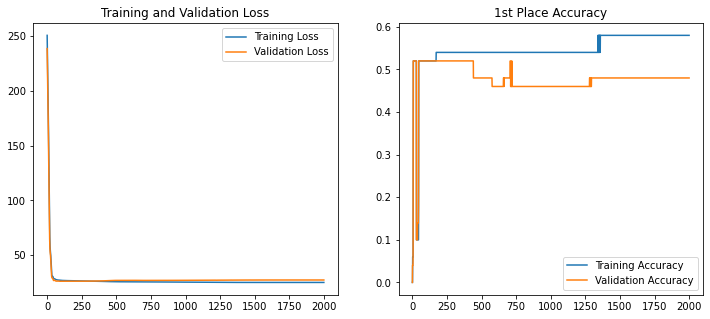

In [11]:
performance = train_model4v1(train_loader, test_loader, epochs=2000, load=False, lr=0.001, viz=True, path=path)

# Model 4 version 2
- RaceMultiOutputModel4v1
- Cross Entropy Loss
- Adam

In [14]:
path = 'models/RaceMultiOutputModeltvt4v2/'

# Load data
X_train = pd.read_csv('Data/RaceMultiOutPutModeltvt/pos_1lap_X_train.csv')
y_train = pd.read_csv('Data/RaceMultiOutPutModeltvt/Y_train.csv')
X_valid = pd.read_csv('Data/RaceMultiOutPutModeltvt/pos_1lap_X_valid.csv')
y_valid = pd.read_csv('Data/RaceMultiOutPutModeltvt/Y_valid.csv')
X_test = pd.read_csv('Data/RaceMultiOutPutModeltvt/pos_1lap_X_test.csv')
y_test = pd.read_csv('Data/RaceMultiOutPutModeltvt/Y_test.csv')

X_train.drop(['raceId'],axis=1, inplace=True)
y_train.drop(['raceId'],axis=1, inplace=True)
X_valid.drop(['raceId'],axis=1, inplace=True)
y_valid.drop(['raceId'],axis=1, inplace=True)
X_test.drop(['raceId'],axis=1, inplace=True)
y_test.drop(['raceId'],axis=1, inplace=True)


# Create Dataset and DataLoader for train and test sets
train_dataset = RaceDataset(torch.tensor(X_train.values, dtype=torch.float32), torch.tensor(y_train.values, dtype=torch.float32))
valid_dataset = RaceDataset(torch.tensor(X_valid.values, dtype=torch.float32), torch.tensor(y_valid.values, dtype=torch.float32))
test_dataset = RaceDataset(torch.tensor(X_test.values, dtype=torch.float32), torch.tensor(y_test.values, dtype=torch.float32))

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)
train_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

def train_model4v2(train_loader, test_loader, epochs=10, load=False, lr=0.001, viz=False, path=None):


    if not os.path.exists(path):
        os.makedirs(path)

    model = RaceMultiOutputModel4()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    if not load:
        prev_epoch = 0
        performance = pd.DataFrame()
        print('New model created')
    else:
        checkpoint = torch.load(f'{path}model.pt')
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        prev_epoch = checkpoint['epoch']
        performance = checkpoint['performance']

    first_epoch = prev_epoch + 1
    last_epoch = epochs + first_epoch - 1

    training_losses = []
    validation_losses = []

    train_fp_accs = []
    val_fp_accs = []

    with tqdm(total=last_epoch, initial=first_epoch-1, desc='Training Progress', unit='epoch') as epoch_pbar:
        for epoch in range(first_epoch, last_epoch + 1):
            # Training Phase
            model.train()
            train_loss = 0.0
            # first place prediction accuracy
            correct_first_place_predictions = 0
            total_races = 0

            for inputs, targets in train_loader:
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()

                # Predicted and actual first-place finishers
                predicted_first_places = outputs.argmin(dim=1)
                actual_first_places = targets.argmin(dim=1)

                correct_first_place_predictions += (predicted_first_places == actual_first_places).sum().item()
                total_races += inputs.size(0)

            average_train_loss = train_loss / len(train_loader)
            training_losses.append(average_train_loss)
            train_outputs = outputs

            # Calculate the accuracy
            train_fp_acc = correct_first_place_predictions / total_races
            train_fp_accs.append(train_fp_acc)

            # Validation Phase
            model.eval()

            val_loss = 0.0

            # first place prediction accuracy
            correct_first_place_predictions = 0
            total_races = 0

            with torch.no_grad():
                for inputs, targets in test_loader:
                    outputs = model(inputs)
                    loss = criterion(outputs, targets)
                    val_loss += loss.item()

                    # Predicted and actual first-place finishers
                    predicted_first_places = outputs.argmin(dim=1)
                    actual_first_places = targets.argmin(dim=1)

                    correct_first_place_predictions += (predicted_first_places == actual_first_places).sum().item()
                    total_races += inputs.size(0)

                average_val_loss = val_loss / len(test_loader)
                validation_losses.append(average_val_loss)
                val_outputs = outputs

                # Calculate the accuracy
                val_fp_acc = correct_first_place_predictions / total_races
                val_fp_accs.append(val_fp_acc)
                
            epoch_pbar.set_description(f'Epoch {epoch}/{last_epoch} - Train Acc: {train_fp_acc:.2f} | Val Acc: {val_fp_acc:.2f}')
            epoch_pbar.update(1)

    performance = performance.append(pd.DataFrame({'epoch': list(range(first_epoch, last_epoch+1)), 'training_losses': training_losses, 'validation_losses': validation_losses, 'train_fp_acc': train_fp_accs, 'val_fp_acc': val_fp_accs}), ignore_index=True)


    if viz:
        visualize(performance, path, save=True)
    torch.save({
        'epoch': last_epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'performance': performance,
    }, f'{path}model.pt')
    print('Model saved')
    notify('Training Complete', path.split('/')[-1])
    return performance

New model created


Epoch 2000/2000 - Train Acc: 0.58 | Val Acc: 0.48: 100%|██████████| 2000/2000 [00:06<00:00, 325.04epoch/s]


Model saved


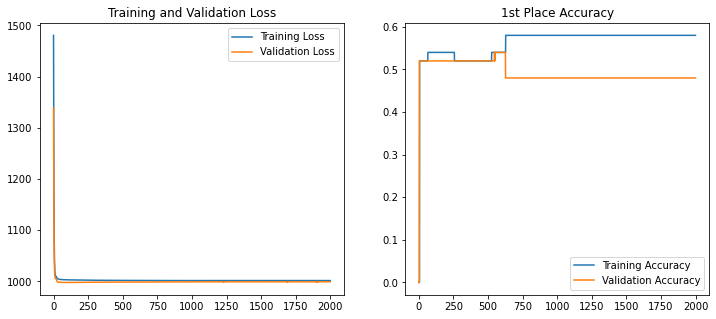

In [15]:
performance = train_model4v2(train_loader, test_loader, epochs=2000, load=False, lr=0.001, viz=True, path=path)

# Model 4 v3
- spearman_rank_loss

In [16]:
path = 'models/RaceMultiOutputModeltvt4v3/'

# Load data
X_train = pd.read_csv('Data/RaceMultiOutPutModeltvt/pos_1lap_X_train.csv')
y_train = pd.read_csv('Data/RaceMultiOutPutModeltvt/Y_train.csv')
X_valid = pd.read_csv('Data/RaceMultiOutPutModeltvt/pos_1lap_X_valid.csv')
y_valid = pd.read_csv('Data/RaceMultiOutPutModeltvt/Y_valid.csv')
X_test = pd.read_csv('Data/RaceMultiOutPutModeltvt/pos_1lap_X_test.csv')
y_test = pd.read_csv('Data/RaceMultiOutPutModeltvt/Y_test.csv')

X_train.drop(['raceId'],axis=1, inplace=True)
y_train.drop(['raceId'],axis=1, inplace=True)
X_valid.drop(['raceId'],axis=1, inplace=True)
y_valid.drop(['raceId'],axis=1, inplace=True)
X_test.drop(['raceId'],axis=1, inplace=True)
y_test.drop(['raceId'],axis=1, inplace=True)


# Create Dataset and DataLoader for train and test sets
train_dataset = RaceDataset(torch.tensor(X_train.values, dtype=torch.float32), torch.tensor(y_train.values, dtype=torch.float32))
valid_dataset = RaceDataset(torch.tensor(X_valid.values, dtype=torch.float32), torch.tensor(y_valid.values, dtype=torch.float32))
test_dataset = RaceDataset(torch.tensor(X_test.values, dtype=torch.float32), torch.tensor(y_test.values, dtype=torch.float32))

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)
train_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

def train_model4v3(train_loader, test_loader, epochs=10, load=False, lr=0.001, viz=False, path=None):


    if not os.path.exists(path):
        os.makedirs(path)

    model = RaceMultiOutputModel4()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    #criterion = nn.CrossEntropyLoss()

    if not load:
        prev_epoch = 0
        performance = pd.DataFrame()
        print('New model created')
    else:
        checkpoint = torch.load(f'{path}model.pt')
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        prev_epoch = checkpoint['epoch']
        performance = checkpoint['performance']

    first_epoch = prev_epoch + 1
    last_epoch = epochs + first_epoch - 1

    training_losses = []
    validation_losses = []

    train_fp_accs = []
    val_fp_accs = []

    with tqdm(total=last_epoch, initial=first_epoch-1, desc='Training Progress', unit='epoch') as epoch_pbar:
        for epoch in range(first_epoch, last_epoch + 1):
            # Training Phase
            model.train()
            train_loss = 0.0
            # first place prediction accuracy
            correct_first_place_predictions = 0
            total_races = 0

            for inputs, targets in train_loader:
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = spearman_rank_loss(outputs, targets)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()

                # Predicted and actual first-place finishers
                predicted_first_places = outputs.argmin(dim=1)
                actual_first_places = targets.argmin(dim=1)

                correct_first_place_predictions += (predicted_first_places == actual_first_places).sum().item()
                total_races += inputs.size(0)

            average_train_loss = train_loss / len(train_loader)
            training_losses.append(average_train_loss)
            train_outputs = outputs

            # Calculate the accuracy
            train_fp_acc = correct_first_place_predictions / total_races
            train_fp_accs.append(train_fp_acc)

            # Validation Phase
            model.eval()

            val_loss = 0.0

            # first place prediction accuracy
            correct_first_place_predictions = 0
            total_races = 0

            with torch.no_grad():
                for inputs, targets in test_loader:
                    outputs = model(inputs)
                    loss = spearman_rank_loss(outputs, targets)
                    val_loss += loss.item()

                    # Predicted and actual first-place finishers
                    predicted_first_places = outputs.argmin(dim=1)
                    actual_first_places = targets.argmin(dim=1)

                    correct_first_place_predictions += (predicted_first_places == actual_first_places).sum().item()
                    total_races += inputs.size(0)

                average_val_loss = val_loss / len(test_loader)
                validation_losses.append(average_val_loss)
                val_outputs = outputs

                # Calculate the accuracy
                val_fp_acc = correct_first_place_predictions / total_races
                val_fp_accs.append(val_fp_acc)
                
            epoch_pbar.set_description(f'Epoch {epoch}/{last_epoch} - Train Acc: {train_fp_acc:.2f} | Val Acc: {val_fp_acc:.2f}')
            epoch_pbar.update(1)

    performance = performance.append(pd.DataFrame({'epoch': list(range(first_epoch, last_epoch+1)), 'training_losses': training_losses, 'validation_losses': validation_losses, 'train_fp_acc': train_fp_accs, 'val_fp_acc': val_fp_accs}), ignore_index=True)


    if viz:
        visualize(performance, path, save=True)
    torch.save({
        'epoch': last_epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'performance': performance,
    }, f'{path}model.pt')
    print('Model saved')
    notify('Training Complete', path.split('/')[-1])
    return performance

Epoch 101/2000 - Train Acc: 0.02 | Val Acc: 0.00:   5%|▌         | 100/2000 [00:00<?, ?epoch/s]

Epoch 2000/2000 - Train Acc: 0.00 | Val Acc: 0.00: 100%|██████████| 2000/2000 [00:06<00:00, 298.88epoch/s]


Model saved


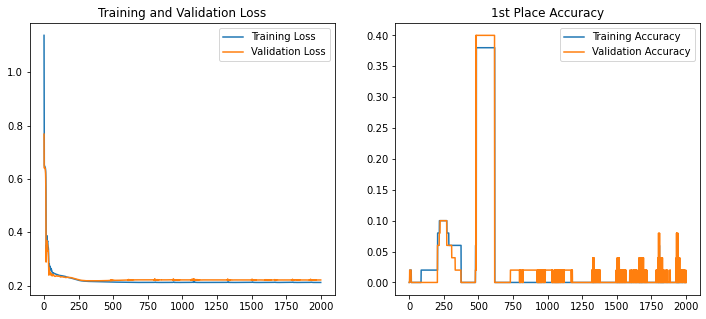

In [18]:
perfomance = train_model4v3(train_loader, test_loader, epochs=1900, load=True, lr=0.001, viz=True, path=path)

# Model 4 version 4
- weighted_ranking_loss

In [19]:
path = 'models/RaceMultiOutputModeltvt4v4/'

# Load data
X_train = pd.read_csv('Data/RaceMultiOutPutModeltvt/pos_1lap_X_train.csv')
y_train = pd.read_csv('Data/RaceMultiOutPutModeltvt/Y_train.csv')
X_valid = pd.read_csv('Data/RaceMultiOutPutModeltvt/pos_1lap_X_valid.csv')
y_valid = pd.read_csv('Data/RaceMultiOutPutModeltvt/Y_valid.csv')
X_test = pd.read_csv('Data/RaceMultiOutPutModeltvt/pos_1lap_X_test.csv')
y_test = pd.read_csv('Data/RaceMultiOutPutModeltvt/Y_test.csv')

X_train.drop(['raceId'],axis=1, inplace=True)
y_train.drop(['raceId'],axis=1, inplace=True)
X_valid.drop(['raceId'],axis=1, inplace=True)
y_valid.drop(['raceId'],axis=1, inplace=True)
X_test.drop(['raceId'],axis=1, inplace=True)
y_test.drop(['raceId'],axis=1, inplace=True)


# Create Dataset and DataLoader for train and test sets
train_dataset = RaceDataset(torch.tensor(X_train.values, dtype=torch.float32), torch.tensor(y_train.values, dtype=torch.float32))
valid_dataset = RaceDataset(torch.tensor(X_valid.values, dtype=torch.float32), torch.tensor(y_valid.values, dtype=torch.float32))
test_dataset = RaceDataset(torch.tensor(X_test.values, dtype=torch.float32), torch.tensor(y_test.values, dtype=torch.float32))

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)
train_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

def train_model4v4(train_loader, test_loader, epochs=10, load=False, lr=0.001, viz=False, path=None):


    if not os.path.exists(path):
        os.makedirs(path)

    model = RaceMultiOutputModel4()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    #criterion = nn.CrossEntropyLoss()

    if not load:
        prev_epoch = 0
        performance = pd.DataFrame()
        print('New model created')
    else:
        checkpoint = torch.load(f'{path}model.pt')
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        prev_epoch = checkpoint['epoch']
        performance = checkpoint['performance']

    first_epoch = prev_epoch + 1
    last_epoch = epochs + first_epoch - 1

    training_losses = []
    validation_losses = []

    train_fp_accs = []
    val_fp_accs = []

    with tqdm(total=last_epoch, initial=first_epoch-1, desc='Training Progress', unit='epoch') as epoch_pbar:
        for epoch in range(first_epoch, last_epoch + 1):
            # Training Phase
            model.train()
            train_loss = 0.0
            # first place prediction accuracy
            correct_first_place_predictions = 0
            total_races = 0

            for inputs, targets in train_loader:
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = weighted_ranking_loss(outputs, targets)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()

                # Predicted and actual first-place finishers
                predicted_first_places = outputs.argmin(dim=1)
                actual_first_places = targets.argmin(dim=1)

                correct_first_place_predictions += (predicted_first_places == actual_first_places).sum().item()
                total_races += inputs.size(0)

            average_train_loss = train_loss / len(train_loader)
            training_losses.append(average_train_loss)
            train_outputs = outputs

            # Calculate the accuracy
            train_fp_acc = correct_first_place_predictions / total_races
            train_fp_accs.append(train_fp_acc)

            # Validation Phase
            model.eval()

            val_loss = 0.0

            # first place prediction accuracy
            correct_first_place_predictions = 0
            total_races = 0

            with torch.no_grad():
                for inputs, targets in test_loader:
                    outputs = model(inputs)
                    loss = weighted_ranking_loss(outputs, targets)
                    val_loss += loss.item()

                    # Predicted and actual first-place finishers
                    predicted_first_places = outputs.argmin(dim=1)
                    actual_first_places = targets.argmin(dim=1)

                    correct_first_place_predictions += (predicted_first_places == actual_first_places).sum().item()
                    total_races += inputs.size(0)

                average_val_loss = val_loss / len(test_loader)
                validation_losses.append(average_val_loss)
                val_outputs = outputs

                # Calculate the accuracy
                val_fp_acc = correct_first_place_predictions / total_races
                val_fp_accs.append(val_fp_acc)
                
            epoch_pbar.set_description(f'Epoch {epoch}/{last_epoch} - Train Acc: {train_fp_acc:.2f} | Val Acc: {val_fp_acc:.2f}')
            epoch_pbar.update(1)

    performance = performance.append(pd.DataFrame({'epoch': list(range(first_epoch, last_epoch+1)), 'training_losses': training_losses, 'validation_losses': validation_losses, 'train_fp_acc': train_fp_accs, 'val_fp_acc': val_fp_accs}), ignore_index=True)


    if viz:
        visualize(performance, path, save=True)
    torch.save({
        'epoch': last_epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'performance': performance,
    }, f'{path}model.pt')
    print('Model saved')
    notify('Training Complete', path.split('/')[-1])
    return performance

New model created


Training Progress:   0%|          | 0/190 [00:00<?, ?epoch/s]

Epoch 190/190 - Train Acc: 0.54 | Val Acc: 0.52: 100%|██████████| 190/190 [07:02<00:00,  2.22s/epoch]


Model saved


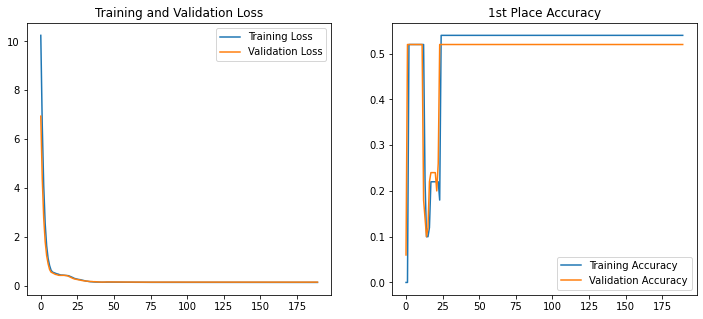

In [23]:
performance = train_model4v4(train_loader, test_loader, epochs=190, load=False, lr=0.001, viz=True, path=path)

# Model 4 version 5
- winner weight = 10

In [25]:
path = 'models/RaceMultiOutputModeltvt4v5/'

# Load data
X_train = pd.read_csv('Data/RaceMultiOutPutModeltvt/pos_1lap_X_train.csv')
y_train = pd.read_csv('Data/RaceMultiOutPutModeltvt/Y_train.csv')
X_valid = pd.read_csv('Data/RaceMultiOutPutModeltvt/pos_1lap_X_valid.csv')
y_valid = pd.read_csv('Data/RaceMultiOutPutModeltvt/Y_valid.csv')
X_test = pd.read_csv('Data/RaceMultiOutPutModeltvt/pos_1lap_X_test.csv')
y_test = pd.read_csv('Data/RaceMultiOutPutModeltvt/Y_test.csv')

X_train.drop(['raceId'],axis=1, inplace=True)
y_train.drop(['raceId'],axis=1, inplace=True)
X_valid.drop(['raceId'],axis=1, inplace=True)
y_valid.drop(['raceId'],axis=1, inplace=True)
X_test.drop(['raceId'],axis=1, inplace=True)
y_test.drop(['raceId'],axis=1, inplace=True)


# Create Dataset and DataLoader for train and test sets
train_dataset = RaceDataset(torch.tensor(X_train.values, dtype=torch.float32), torch.tensor(y_train.values, dtype=torch.float32))
valid_dataset = RaceDataset(torch.tensor(X_valid.values, dtype=torch.float32), torch.tensor(y_valid.values, dtype=torch.float32))
test_dataset = RaceDataset(torch.tensor(X_test.values, dtype=torch.float32), torch.tensor(y_test.values, dtype=torch.float32))

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)
train_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

def train_model4v5(train_loader, test_loader, epochs=10, load=False, lr=0.001, viz=False, path=None):


    if not os.path.exists(path):
        os.makedirs(path)

    model = RaceMultiOutputModel4()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    #criterion = nn.CrossEntropyLoss()

    if not load:
        prev_epoch = 0
        performance = pd.DataFrame()
        print('New model created')
    else:
        checkpoint = torch.load(f'{path}model.pt')
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        prev_epoch = checkpoint['epoch']
        performance = checkpoint['performance']

    first_epoch = prev_epoch + 1
    last_epoch = epochs + first_epoch - 1

    training_losses = []
    validation_losses = []

    train_fp_accs = []
    val_fp_accs = []

    with tqdm(total=last_epoch, initial=first_epoch-1, desc='Training Progress', unit='epoch') as epoch_pbar:
        for epoch in range(first_epoch, last_epoch + 1):
            # Training Phase
            model.train()
            train_loss = 0.0
            # first place prediction accuracy
            correct_first_place_predictions = 0
            total_races = 0

            for inputs, targets in train_loader:
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = weighted_ranking_loss(outputs, targets, winner_weight=10)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()

                # Predicted and actual first-place finishers
                predicted_first_places = outputs.argmin(dim=1)
                actual_first_places = targets.argmin(dim=1)

                correct_first_place_predictions += (predicted_first_places == actual_first_places).sum().item()
                total_races += inputs.size(0)

            average_train_loss = train_loss / len(train_loader)
            training_losses.append(average_train_loss)
            train_outputs = outputs

            # Calculate the accuracy
            train_fp_acc = correct_first_place_predictions / total_races
            train_fp_accs.append(train_fp_acc)

            # Validation Phase
            model.eval()

            val_loss = 0.0

            # first place prediction accuracy
            correct_first_place_predictions = 0
            total_races = 0

            with torch.no_grad():
                for inputs, targets in test_loader:
                    outputs = model(inputs)
                    loss = weighted_ranking_loss(outputs, targets, winner_weight=10)
                    val_loss += loss.item()

                    # Predicted and actual first-place finishers
                    predicted_first_places = outputs.argmin(dim=1)
                    actual_first_places = targets.argmin(dim=1)

                    correct_first_place_predictions += (predicted_first_places == actual_first_places).sum().item()
                    total_races += inputs.size(0)

                average_val_loss = val_loss / len(test_loader)
                validation_losses.append(average_val_loss)
                val_outputs = outputs

                # Calculate the accuracy
                val_fp_acc = correct_first_place_predictions / total_races
                val_fp_accs.append(val_fp_acc)
                
            epoch_pbar.set_description(f'Epoch {epoch}/{last_epoch} - Train Acc: {train_fp_acc:.2f} | Val Acc: {val_fp_acc:.2f}')
            epoch_pbar.update(1)

    performance = performance.append(pd.DataFrame({'epoch': list(range(first_epoch, last_epoch+1)), 'training_losses': training_losses, 'validation_losses': validation_losses, 'train_fp_acc': train_fp_accs, 'val_fp_acc': val_fp_accs}), ignore_index=True)


    if viz:
        visualize(performance, path, save=True)
    torch.save({
        'epoch': last_epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'performance': performance,
    }, f'{path}model.pt')
    print('Model saved')
    notify('Training Complete', path.split('/')[-1])
    return performance

New model created


Epoch 200/200 - Train Acc: 0.54 | Val Acc: 0.52: 100%|██████████| 200/200 [07:31<00:00,  2.26s/epoch]


Model saved


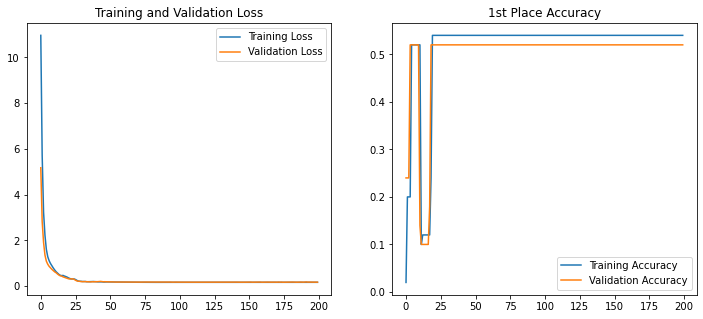

In [26]:
performance = train_model4v5(train_loader, test_loader, epochs=200, load=False, lr=0.001, viz=True, path=path)

0's instead of winner for Y


- logits -- softmax
- edit distance -- 24 drivers -- figure out what the pariwise edit distance between all 500 races -- pick the ones with minimum edit distance -- this could tell you 


pick the hundred closest edit distances -- use these as new training data to see if model improves


- how well model predicts for non-prominent drivers
- how well model predicts for 



- 500 races -- 



- predict last place





In [ ]:
# Model 3
- 24 lap positions
    model = RaceMultiOutputModel3()


In [39]:
path = 'models/RaceMultiOutputModeltvt3v1/'

# Load data
X_train = pd.read_csv('Data/RaceMultiOutPutModeltvt/pos_10lap_X_train.csv')
y_train = pd.read_csv('Data/RaceMultiOutPutModeltvt/Y_train.csv')
X_valid = pd.read_csv('Data/RaceMultiOutPutModeltvt/pos_10lap_X_valid.csv')
y_valid = pd.read_csv('Data/RaceMultiOutPutModeltvt/Y_valid.csv')
X_test = pd.read_csv('Data/RaceMultiOutPutModeltvt/pos_10lap_X_test.csv')
y_test = pd.read_csv('Data/RaceMultiOutPutModeltvt/Y_test.csv')

X_train.drop(['raceId'],axis=1, inplace=True)
y_train.drop(['raceId'],axis=1, inplace=True)
X_valid.drop(['raceId'],axis=1, inplace=True)
y_valid.drop(['raceId'],axis=1, inplace=True)
X_test.drop(['raceId'],axis=1, inplace=True)
y_test.drop(['raceId'],axis=1, inplace=True)

X_train = X_train / 25
X_valid = X_valid / 25
X_test = X_test / 25

y_train = y_train / 25
y_valid = y_valid / 25
y_test = y_test / 25


# Create Dataset and DataLoader for train and test sets
train_dataset = RaceDataset(torch.tensor(X_train.values, dtype=torch.float32), torch.tensor(y_train.values, dtype=torch.float32))
valid_dataset = RaceDataset(torch.tensor(X_valid.values, dtype=torch.float32), torch.tensor(y_valid.values, dtype=torch.float32))
test_dataset = RaceDataset(torch.tensor(X_test.values, dtype=torch.float32), torch.tensor(y_test.values, dtype=torch.float32))

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)
train_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

def train_model3v1(train_loader, test_loader, epochs=10, load=False, lr=0.001, viz=False, path=None):


    if not os.path.exists(path):
        os.makedirs(path)

    model = RaceMultiOutputModel3()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    #criterion = nn.CrossEntropyLoss()

    if not load:
        prev_epoch = 0
        performance = pd.DataFrame()
        print('New model created')
    else:
        checkpoint = torch.load(f'{path}model.pt')
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        prev_epoch = checkpoint['epoch']
        performance = checkpoint['performance']

    first_epoch = prev_epoch + 1
    last_epoch = epochs + first_epoch - 1

    training_losses = []
    validation_losses = []

    train_fp_accs = []
    val_fp_accs = []

    with tqdm(total=last_epoch, initial=first_epoch-1, desc='Training Progress', unit='epoch') as epoch_pbar:
        for epoch in range(first_epoch, last_epoch + 1):
            # Training Phase
            model.train()
            train_loss = 0.0
            # first place prediction accuracy
            correct_first_place_predictions = 0
            total_races = 0

            for inputs, targets in train_loader:
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = weighted_ranking_loss(outputs, targets, winner_weight=5)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()

                # Predicted and actual first-place finishers
                predicted_first_places = outputs.argmin(dim=1)
                actual_first_places = targets.argmin(dim=1)

                correct_first_place_predictions += (predicted_first_places == actual_first_places).sum().item()
                total_races += inputs.size(0)

            average_train_loss = train_loss / len(train_loader)
            training_losses.append(average_train_loss)
            train_outputs = outputs

            # Calculate the accuracy
            train_fp_acc = correct_first_place_predictions / total_races
            train_fp_accs.append(train_fp_acc)

            # Validation Phase
            model.eval()

            val_loss = 0.0

            # first place prediction accuracy
            correct_first_place_predictions = 0
            total_races = 0

            with torch.no_grad():
                for inputs, targets in test_loader:
                    outputs = model(inputs)
                    loss = weighted_ranking_loss(outputs, targets, winner_weight=5)
                    val_loss += loss.item()

                    # Predicted and actual first-place finishers
                    predicted_first_places = outputs.argmin(dim=1)
                    actual_first_places = targets.argmin(dim=1)

                    correct_first_place_predictions += (predicted_first_places == actual_first_places).sum().item()
                    total_races += inputs.size(0)

                average_val_loss = val_loss / len(test_loader)
                validation_losses.append(average_val_loss)
                val_outputs = outputs

                # Calculate the accuracy
                val_fp_acc = correct_first_place_predictions / total_races
                val_fp_accs.append(val_fp_acc)
                
            epoch_pbar.set_description(f'Epoch {epoch}/{last_epoch} - Train Acc: {train_fp_acc:.2f} | Val Acc: {val_fp_acc:.2f}')
            epoch_pbar.update(1)

    performance = performance.append(pd.DataFrame({'epoch': list(range(first_epoch, last_epoch+1)), 'training_losses': training_losses, 'validation_losses': validation_losses, 'train_fp_acc': train_fp_accs, 'val_fp_acc': val_fp_accs}), ignore_index=True)


    if viz:
        visualize(performance, path, save=True)
    torch.save({
        'epoch': last_epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'performance': performance,
    }, f'{path}model.pt')
    print('Model saved')
    notify('Training Complete', path.split('/')[-1])
    return performance

Epoch 500/500 - Train Acc: 0.04 | Val Acc: 0.08: 100%|██████████| 500/500 [16:36<00:00,  2.22s/epoch]


Model saved


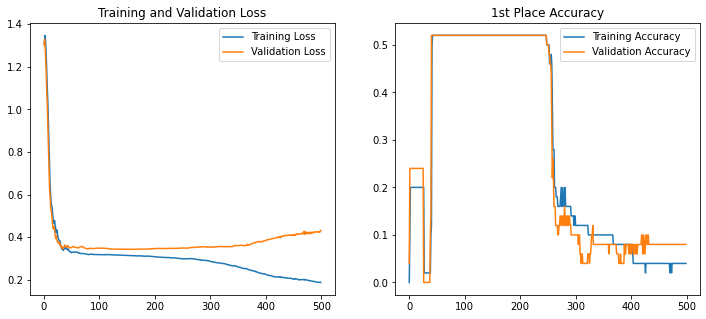

In [41]:
performance = train_model3v1(train_loader, test_loader, epochs=450, load=True, lr=0.001, viz=True, path=path)

# OLD

# Model 1

In [62]:
# Load data
X_train = pd.read_csv('Data/RaceMultiOutPutModel/X_train.csv')
y_train = pd.read_csv('Data/RaceMultiOutPutModel/Y_train.csv')
X_test = pd.read_csv('Data/RaceMultiOutPutModel/X_test.csv')
y_test = pd.read_csv('Data/RaceMultiOutPutModel/Y_test.csv')

X_train.drop(['raceId'],axis=1, inplace=True)
y_train.drop(['raceId'],axis=1, inplace=True)
X_test.drop(['raceId'],axis=1, inplace=True)
y_test.drop(['raceId'],axis=1, inplace=True)

# X_train = X_train[0:4].copy()
# y_train = y_train[0:4].copy()

# Create Dataset and DataLoader for train and test sets
train_dataset = RaceDataset(torch.tensor(X_train.values, dtype=torch.float32), torch.tensor(y_train.values, dtype=torch.float32))
test_dataset = RaceDataset(torch.tensor(X_test.values, dtype=torch.float32), torch.tensor(y_test.values, dtype=torch.float32))

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

model = RaceMultiOutputModel()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Train for each epoch
num_epochs = 10000
for epoch in range(num_epochs):
    # Training Phase
    model.train()
    train_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    average_train_loss = train_loss / len(train_loader)

    # Validation Phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()

    average_val_loss = val_loss / len(test_loader)

    # Print epoch results
    print(f"Epoch {epoch+1}/{num_epochs} - Training Loss: {average_train_loss:.4f}, Validation Loss: {average_val_loss:.4f}")




Epoch 1/10000 - Training Loss: 38675060.3750, Validation Loss: 51727352.0000
Epoch 2/10000 - Training Loss: 15138577.0000, Validation Loss: 28376972.0000
Epoch 3/10000 - Training Loss: 8019004.7188, Validation Loss: 17953416.0000
Epoch 4/10000 - Training Loss: 4918648.0938, Validation Loss: 12480162.0000
Epoch 5/10000 - Training Loss: 3226594.4766, Validation Loss: 9566739.0000
Epoch 6/10000 - Training Loss: 2315285.0469, Validation Loss: 7974680.5000
Epoch 7/10000 - Training Loss: 1760855.8359, Validation Loss: 6922317.0000
Epoch 8/10000 - Training Loss: 1389393.0312, Validation Loss: 6145999.5000
Epoch 9/10000 - Training Loss: 1130829.5000, Validation Loss: 5551358.5000
Epoch 10/10000 - Training Loss: 941492.7344, Validation Loss: 5103310.5000
Epoch 11/10000 - Training Loss: 795440.0859, Validation Loss: 4802614.0000
Epoch 12/10000 - Training Loss: 684230.3672, Validation Loss: 4555140.5000
Epoch 13/10000 - Training Loss: 597073.8477, Validation Loss: 4356466.5000
Epoch 14/10000 - Tr

In [58]:
outputs.shape

torch.Size([56, 24])

In [95]:
outputs[10,:]

tensor([ 2132.8496,  -109.9153,  7614.6948,   603.3745,  4280.2485,  -619.5533,
          304.6798,  -355.9213,  2139.7776,  1770.0221, -4010.8945,  -778.2469,
        -5491.2778,  3078.9614,   599.1963,  8373.9287,   -42.8887,  -196.1759,
        -2035.7766,  -961.1223, -3677.4067, -4075.8887,  6648.4253,  -475.8877])

In [77]:
def map_outputs_order(outputs):
    outputs = outputs.detach().numpy()

    #outputs = np.argsort(outputs, axis=-1, kind=None, order=None) + 1
    outputs = np.array([row.argsort().argsort() for row in outputs]) + 1
    return outputs

t = map_outputs_order(outputs)


def first_place_accuracy(outputs, targets):
    preds = map_outputs_order(outputs)
    targets = targets.detach().numpy()
    idx_first_place = np.where(targets==1)
    pred_first_place = preds[idx_first_place]
    return pred_first_place

print(0)
print(t[0,])
print(y_test.values[0,])
print(1)
print(t[1,])
print(y_test.values[1,])
print(1)
print(t[2,])
print(y_test.values[2,])
first_place_accuracy(outputs, targets)

0
[ 1  2  3  4  5  6 15  9  7 11 10  8 14 12 17 23 18 22 24 20 16 21 19 13]
[ 2  1  6  3 17  4  7 25 10  8 11 12 13 15  9 14 18 16  5 25 25 25 25 25]
1
[ 1  2  3  4  5  6 15  9  7 11 10  8 14 12 17 23 18 22 24 20 16 21 19 13]
[ 1  2  4 11  6  7  8  5  3 25 25 13 14  9 12 16 10 15 17 25 25 25 25 25]
1
[ 1  2  3  4  5  6 15  9  7 11 10  8 14 12 17 23 18 22 24 20 16 21 19 13]
[ 3  1  2 11  4  5  7  6 10 13 16 12 25  9  8 15 14 18 17 19 25 25 25 25]


array([ 2,  1,  2,  2,  1,  4,  2,  1,  1, 13, 12, 11,  1,  1, 15,  1,  2,
        1,  6,  1,  1,  2,  1,  3,  1,  1,  2,  2,  3,  3,  1, 17,  2,  2,
        9,  9,  1,  4,  1,  1,  1,  1,  1,  1,  1,  2, 17,  3,  7,  1,  1,
        1,  1,  2,  1,  4])

In [64]:
def get_mask(y):
    indices_matrix = np.zeros_like(y, dtype=int)

    # Iterate through each row and find indices where the value > 24
    for i in range(y.shape[0]):
        indices = np.where(y[i] > 24)
        indices_matrix[i, indices] = 1

    # Create a new matrix with the indices
    mask = np.multiply(y, indices_matrix)
    return mask
   
mask = get_mask(y_test.values)

masked_true = np.ma.masked_array(y_test, mask, fill_value=0)
masked_pred = np.ma.masked_array(t, mask, fill_value=0)

In [65]:
(masked_true - masked_pred)

masked_array(
  data=[[2, 0, 4, ..., --, --, --],
        [1, 1, 2, ..., --, --, --],
        [3, 0, 0, ..., --, --, --],
        ...,
        [2, 0, 2, ..., --, --, --],
        [1, 4, 0, ..., --, --, --],
        [2, 2, 2, ..., --, --, --]],
  mask=[[False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        ...,
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True]],
  fill_value=0)

In [46]:
arr = np.array([1, 2, 3, 4, 5])

# Create a mask based on a condition
mask = arr > 3

# Apply the mask to the array
masked_arr = np.ma.masked_array(arr, mask, fill_value=0)

# Print the results
print("Original Array:", arr)
print("Masked Array:", masked_arr)

Original Array: [1 2 3 4 5]
Masked Array: [1 2 3 -- --]


In [45]:
x

masked_array(
  data=[[0, 20, 19, ..., --, --, --],
        [0, 11, 12, ..., --, --, --],
        [2, 20, 1, ..., --, --, --],
        ...,
        [0, 20, 1, ..., --, --, --],
        [0, 11, 3, ..., --, --, --],
        [0, 21, 9, ..., --, --, --]],
  mask=[[False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        ...,
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True]],
  fill_value=999999)

In [30]:
for i, row in enumerate(t):
    print(np.sum(row))
print(i)

675
541
525
618
536
664
692
551
656
603
758
615
790
743
701
727
654
622
736
580
888
782
800
766
779
828
715
680
716
900
823
733
821
669
654
632
653
711
686
860
674
605
710
733
676
684
599
557
696
743
451
601
616
617
595
664
55


# Model 2

In [113]:
# Load data
X_train = pd.read_csv('Data/RaceMultiOutPutModel/X_train.csv')
y_train = pd.read_csv('Data/RaceMultiOutPutModel/Y_train.csv')
X_test = pd.read_csv('Data/RaceMultiOutPutModel/X_test.csv')
y_test = pd.read_csv('Data/RaceMultiOutPutModel/Y_test.csv')

X_train.drop(['raceId'],axis=1, inplace=True)
y_train.drop(['raceId'],axis=1, inplace=True)
X_test.drop(['raceId'],axis=1, inplace=True)
y_test.drop(['raceId'],axis=1, inplace=True)

# X_train = X_train[0:4].copy()
# y_train = y_train[0:4].copy()

# Create Dataset and DataLoader for train and test sets
train_dataset = RaceDataset(torch.tensor(X_train.values, dtype=torch.float32), torch.tensor(y_train.values, dtype=torch.float32))
test_dataset = RaceDataset(torch.tensor(X_test.values, dtype=torch.float32), torch.tensor(y_test.values, dtype=torch.float32))

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

model = RaceMultiOutputModel2()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Train for each epoch
num_epochs = 10
for epoch in range(num_epochs):
    # Training Phase
    model.train()
    train_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    average_train_loss = train_loss / len(train_loader)

    # Validation Phase
    # model.eval()
    # val_loss = 0.0
    # with torch.no_grad():
    #     for inputs, targets in test_loader:
    #         outputs = model(inputs)
    #         loss = criterion(outputs, targets)
    #         val_loss += loss.item()

    # average_val_loss = val_loss / len(test_loader)

    # # Print epoch results
    # print(f"Epoch {epoch+1}/{num_epochs} - Training Loss: {average_train_loss:.4f}, Validation Loss: {average_val_loss:.4f}")




In [108]:
outputs[0,]

tensor([24.,  0., 24.,  0.,  0., 24.,  0., 24.,  0., 24., 24.,  0., 24., 24.,
         0., 24., 24., 24., 24., 24., 24., 24., 24., 24.])

In [115]:
outputs[1,]

tensor([ 0., 25.,  0.,  0.,  0.,  0., 25.,  0., 25.,  0., 25., 25.,  0.,  0.,
        25., 25., 25., 25., 25.,  0., 25., 25., 25., 25.],
       grad_fn=<SelectBackward0>)

# Model 3

In [131]:
# Load data
X_train = pd.read_csv('Data/RaceMultiOutPutModel/X_train.csv')
y_train = pd.read_csv('Data/RaceMultiOutPutModel/Y_train.csv')
X_test = pd.read_csv('Data/RaceMultiOutPutModel/X_test.csv')
y_test = pd.read_csv('Data/RaceMultiOutPutModel/Y_test.csv')

X_train.drop(['raceId'],axis=1, inplace=True)
y_train.drop(['raceId'],axis=1, inplace=True)
X_test.drop(['raceId'],axis=1, inplace=True)
y_test.drop(['raceId'],axis=1, inplace=True)

# X_train = X_train[0:4].copy()
# y_train = y_train[0:4].copy()

# Create Dataset and DataLoader for train and test sets
train_dataset = RaceDataset(torch.tensor(X_train.values, dtype=torch.float32), torch.tensor(y_train.values, dtype=torch.float32))
test_dataset = RaceDataset(torch.tensor(X_test.values, dtype=torch.float32), torch.tensor(y_test.values, dtype=torch.float32))

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

model = RaceMultiOutputModel3()
#criterion = weighted_ranking_loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Train for each epoch
num_epochs = 10
with tqdm(total=num_epochs+1, initial=1, desc='Training Progress', unit='epoch') as epoch_pbar:
    for epoch in range(1, num_epochs+1):
        # Training Phase
        model.train()
        train_loss = 0.0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = weighted_ranking_loss(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        average_train_loss = train_loss / len(train_loader)

        # Validation Phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in test_loader:
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()

            average_val_loss = val_loss / len(test_loader)
    
        epoch_pbar.set_description(f'Epoch {epoch}/{num_epochs} - Avg Loss: {epoch_average_val_loss:.2f}')
        epoch_pbar.update(1)

torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss,
}, 'models/RaceMultiOutputModel3.pt')



Epoch 10/10 - Avg Loss: 145271584.00: 100%|██████████| 10/10 [02:43<00:00, 16.31s/epoch]


In [132]:
model = RaceMultiOutputModel3()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

checkpoint = torch.load('models/RaceMultiOutputModel3.pt')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
last_epoch = checkpoint['epoch']
last_loss = checkpoint['loss']

model.train()  # Ensure the model is in training mode

num_epochs = 50 + last_epoch+1
with tqdm(total=num_epochs, initial=last_epoch, desc='Training Progress', unit='epoch') as epoch_pbar:
    for epoch in range(last_epoch, num_epochs):
        # Training Phase
        model.train()
        train_loss = 0.0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = weighted_ranking_loss(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        average_train_loss = train_loss / len(train_loader)

        # Validation Phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in test_loader:
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()

        epoch_average_val_loss = val_loss / len(test_loader)
    
        epoch_pbar.set_description(f'Epoch {epoch + 1}/{num_epochs} - Avg Loss: {epoch_average_val_loss:.2f}')
        epoch_pbar.update(1)

torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss,
}, 'models/RaceMultiOutputModel3.pt')


Epoch 59/59 - Avg Loss: 80221144.00:  85%|████████▍ | 50/59 [13:32<02:26, 16.24s/epoch] 


In [155]:
model = RaceMultiOutputModel3()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

checkpoint = torch.load('models/RaceMultiOutputModel3.pt')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
last_epoch = checkpoint['epoch']
last_loss = checkpoint['loss']
print(last_epoch)

70


In [156]:
num_epochs = 10 + last_epoch

training_losses = []
validation_losses = []

with tqdm(total=num_epochs, initial=last_epoch+1, desc='Training Progress', unit='epoch') as epoch_pbar:
    for epoch in range(last_epoch+1, num_epochs+1):
        # Training Phase
        model.train()
        train_loss = 0.0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = weighted_ranking_loss(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        average_train_loss = train_loss / len(train_loader)
        training_losses.append(average_train_loss)

        # Validation Phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in test_loader:
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()
            
            average_val_loss = val_loss / len(test_loader)
            validation_losses.append(average_val_loss)

        epoch_pbar.set_description(f'Epoch {epoch}/{num_epochs} - Avg Loss: {average_val_loss:.2f}')
        epoch_pbar.update(1)
if losses:
    losses = losses.append(pd.DataFrame({'epoch': range(last_epoch, num_epochs+1), 'training_losses': training_losses, 'validation_losses': validation_losses}))
else:
    losses = pd.DataFrame({'epoch': range(last_epoch, num_epochs+1), 'training_losses': training_losses, 'validation_losses': validation_losses})

torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss,
    'losses': losses,
}, 'models/RaceMultiOutputModel3.pt')


Training Progress:  89%|████████▉ | 71/80 [00:00<?, ?epoch/s]

Epoch 80/80 - Avg Loss: 71944152.00: : 81epoch [02:42, 16.23s/epoch]                   


ValueError: The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [152]:
losses

,epoch,training_losses,validation_losses
0,60,819.328728,79110720.0
1,61,798.120491,78827208.0
2,62,785.596400,78420000.0
3,63,767.772891,78149240.0
4,64,762.047411,77937856.0
5,65,748.590104,77559696.0
6,66,735.694262,77463752.0
7,67,723.841270,77016552.0
8,68,717.927728,76314216.0
9,69,700.373106,76054688.0


In [169]:
# Load data
X_train = pd.read_csv('Data/RaceMultiOutPutModel/X_train.csv')
y_train = pd.read_csv('Data/RaceMultiOutPutModel/Y_train.csv')
X_test = pd.read_csv('Data/RaceMultiOutPutModel/X_test.csv')
y_test = pd.read_csv('Data/RaceMultiOutPutModel/Y_test.csv')

X_train.drop(['raceId'],axis=1, inplace=True)
y_train.drop(['raceId'],axis=1, inplace=True)
X_test.drop(['raceId'],axis=1, inplace=True)
y_test.drop(['raceId'],axis=1, inplace=True)

# X_train = X_train[0:4].copy()
# y_train = y_train[0:4].copy()

# Create Dataset and DataLoader for train and test sets
train_dataset = RaceDataset(torch.tensor(X_train.values, dtype=torch.float32), torch.tensor(y_train.values, dtype=torch.float32))
test_dataset = RaceDataset(torch.tensor(X_test.values, dtype=torch.float32), torch.tensor(y_test.values, dtype=torch.float32))

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

model = RaceMultiOutputModel3()
#criterion = weighted_ranking_loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Train for each epoch

prev_epoch = 0
start_epoch = prev_epoch + 1
num_epochs = 3
last_epoch = num_epochs + start_epoch - 1

training_losses = []
validation_losses = []
losses = pd.DataFrame()

with tqdm(total=last_epoch, initial=start_epoch-1, desc='Training Progress', unit='epoch') as epoch_pbar:
    for epoch in range(start_epoch, last_epoch + 1):
        # Training Phase
        model.train()
        train_loss = 0.0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = weighted_ranking_loss(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        average_train_loss = train_loss / len(train_loader)
        training_losses.append(average_train_loss)

        # Validation Phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in test_loader:
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()

            average_val_loss = val_loss / len(test_loader)
            validation_losses.append(average_val_loss)
            
        epoch_pbar.set_description(f'Epoch {epoch}/{last_epoch} - Avg Loss: {average_val_loss:.2f}')
        epoch_pbar.update(1)

losses = losses.append(pd.DataFrame({'epoch': range(start_epoch, last_epoch+1), 'training_losses': training_losses, 'validation_losses': validation_losses}))

torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'losses': losses,
}, 'models/RaceMultiOutputModel3.pt')



Epoch 3/3 - Avg Loss: 249.46: 100%|██████████| 3/3 [00:47<00:00, 15.72s/epoch]      


In [195]:
def train_model3(train_loader, test_loader, epochs=10, load=False, viz=False):

    path = 'models/RaceMultiOutputModel3/'
    model = RaceMultiOutputModel3()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

    if not load:
        prev_epoch = 0
        losses = pd.DataFrame()
        print('New model created')
    else:
        checkpoint = torch.load(f'{path}model.pt')
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        prev_epoch = checkpoint['epoch']
        losses = checkpoint['losses']

    first_epoch = prev_epoch + 1
    last_epoch = epochs + first_epoch - 1
    
    training_losses = []
    validation_losses = []

    with tqdm(total=last_epoch, initial=first_epoch-1, desc='Training Progress', unit='epoch') as epoch_pbar:
        for epoch in range(first_epoch, last_epoch + 1):
            # Training Phase
            model.train()
            train_loss = 0.0
            for inputs, targets in train_loader:
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = weighted_ranking_loss(outputs, targets)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()

            average_train_loss = train_loss / len(train_loader)
            training_losses.append(average_train_loss)
            train_outputs = outputs

            # Validation Phase
            model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for inputs, targets in test_loader:
                    outputs = model(inputs)
                    loss = criterion(outputs, targets)
                    val_loss += loss.item()

                average_val_loss = val_loss / len(test_loader)
                validation_losses.append(average_val_loss)
                val_outputs = outputs
                
            epoch_pbar.set_description(f'Epoch {epoch}/{last_epoch} - Avg Loss: {average_val_loss:.2f}')
            epoch_pbar.update(1)
    
    losses = losses.append(pd.DataFrame({'epoch': list(range(first_epoch, last_epoch+1)), 'training_losses': training_losses, 'validation_losses': validation_losses}), ignore_index=True)

    if viz:
        plot_learning_curves(losses, path, save=True)
    torch.save({
        'epoch': last_epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'losses': losses,
    }, f'{path}model.pt')
    print('Model saved')
    return losses
        

Epoch 60/60 - Avg Loss: 77783176.00: 100%|██████████| 60/60 [04:01<00:00, 16.08s/epoch]

Model saved


,epoch,training_losses,validation_losses
44,45,1365.014915,83271968.0
45,46,1343.658306,82684800.0
46,47,1314.892715,82207088.0
47,48,1297.606129,82233208.0
48,49,1279.083290,81846544.0
49,50,1254.800293,81168448.0
50,51,1229.237724,80819440.0
51,52,1222.750599,80246552.0
52,53,1200.991516,79837336.0
53,54,1175.143330,79882728.0


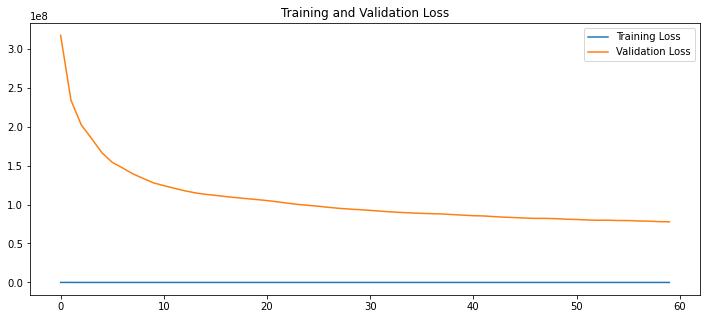

In [203]:
losses = train_model3(train_loader, test_loader, epochs=15, load=True, viz=True)
display(losses.tail(16))
notify('Training Complete', 'RaceMultiOutputModel3')

Epoch 11/11 - Train Acc: 0.39 | Val Acc: 0.50: 100%|██████████| 11/11 [02:38<00:00, 15.83s/epoch]


Model saved


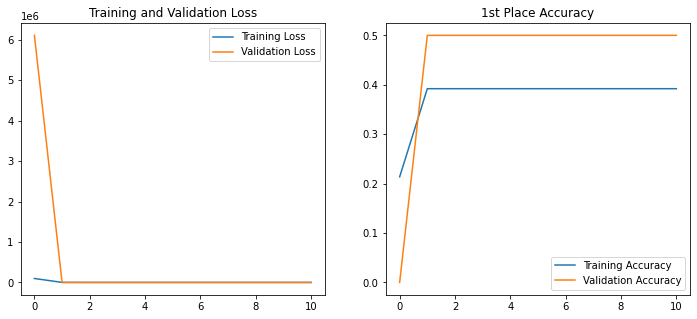

In [224]:
# Model 3 version 2
#def train_model3(train_loader, test_loader, epochs=10, load=False, lr=0.0001, viz=False, path='models/RaceMultiOutputModel3v2/'):

epochs = 10
load = True
lr = 0.01
viz = True
path = 'models/RaceMultiOutputModel3v2/'

if not os.path.exists(path):
    os.makedirs(path)

model = RaceMultiOutputModel3()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

if not load:
    prev_epoch = 0
    performance = pd.DataFrame()
    print('New model created')
else:
    checkpoint = torch.load(f'{path}model.pt')
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    prev_epoch = checkpoint['epoch']
    performance = checkpoint['performance']

first_epoch = prev_epoch + 1
last_epoch = epochs + first_epoch - 1

training_losses = []
validation_losses = []

training_fp_acc = []
validation_fp_acc = []

with tqdm(total=last_epoch, initial=first_epoch-1, desc='Training Progress', unit='epoch') as epoch_pbar:
    for epoch in range(first_epoch, last_epoch + 1):
        # Training Phase
        model.train()
        train_loss = 0.0
        # first place prediction accuracy
        correct_first_place_predictions = 0
        total_races = 0

        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = weighted_ranking_loss(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            # Predicted and actual first-place finishers
            predicted_first_places = outputs.argmin(dim=1)
            actual_first_places = targets.argmin(dim=1)

            correct_first_place_predictions += (predicted_first_places == actual_first_places).sum().item()
            total_races += inputs.size(0)

        average_train_loss = train_loss / len(train_loader)
        training_losses.append(average_train_loss)
        train_outputs = outputs

         # Calculate the accuracy
        train_fp_acc = correct_first_place_predictions / total_races
        training_fp_acc.append(training_fp_acc)

        # Validation Phase
        model.eval()

        val_loss = 0.0

        # first place prediction accuracy
        correct_first_place_predictions = 0
        total_races = 0

        with torch.no_grad():
            for inputs, targets in test_loader:
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()

                # Predicted and actual first-place finishers
                predicted_first_places = outputs.argmin(dim=1)
                actual_first_places = targets.argmin(dim=1)

                correct_first_place_predictions += (predicted_first_places == actual_first_places).sum().item()
                total_races += inputs.size(0)

            average_val_loss = val_loss / len(test_loader)
            validation_losses.append(average_val_loss)
            val_outputs = outputs

            # Calculate the accuracy
            val_fp_acc = correct_first_place_predictions / total_races
            validation_fp_acc.append(val_fp_acc)
            
        epoch_pbar.set_description(f'Epoch {epoch}/{last_epoch} - Train Acc: {train_fp_acc:.2f} | Val Acc: {val_fp_acc:.2f}')
        epoch_pbar.update(1)

performance = performance.append(pd.DataFrame({'epoch': list(range(first_epoch, last_epoch+1)), 'training_losses': training_losses, 'validation_losses': validation_losses, 'train_fp_acc': train_fp_acc, 'val_fp_acc': val_fp_acc}), ignore_index=True)


if viz:
    visualize(performance, path, save=True)
torch.save({
    'epoch': last_epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'performance': performance,
}, f'{path}model.pt')
print('Model saved')
notify('Training Complete', 'RaceMultiOutputModel3v2')
        

New model created


Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]

Epoch 20/20 - Train Acc: 0.09 | Val Acc: 0.00: 100%|██████████| 20/20 [05:21<00:00, 16.07s/epoch]


Model saved


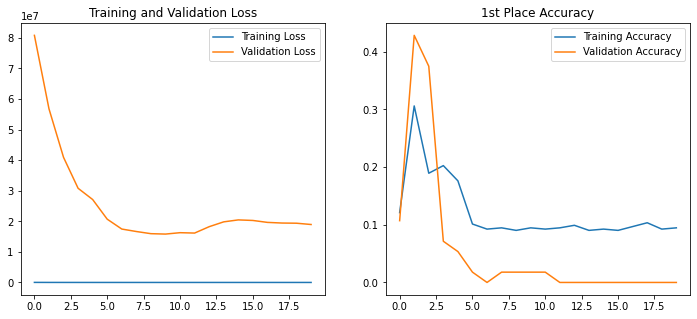

In [229]:
# Model 3 version 3
def train_model3(train_loader, test_loader, epochs=10, load=False, lr=0.001, viz=False, path='models/RaceMultiOutputModel3v3/'):


    if not os.path.exists(path):
        os.makedirs(path)

    model = RaceMultiOutputModel3()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    if not load:
        prev_epoch = 0
        performance = pd.DataFrame()
        print('New model created')
    else:
        checkpoint = torch.load(f'{path}model.pt')
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        prev_epoch = checkpoint['epoch']
        performance = checkpoint['performance']

    first_epoch = prev_epoch + 1
    last_epoch = epochs + first_epoch - 1

    training_losses = []
    validation_losses = []

    train_fp_accs = []
    val_fp_accs = []

    with tqdm(total=last_epoch, initial=first_epoch-1, desc='Training Progress', unit='epoch') as epoch_pbar:
        for epoch in range(first_epoch, last_epoch + 1):
            # Training Phase
            model.train()
            train_loss = 0.0
            # first place prediction accuracy
            correct_first_place_predictions = 0
            total_races = 0

            for inputs, targets in train_loader:
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = weighted_ranking_loss(outputs, targets)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()

                # Predicted and actual first-place finishers
                predicted_first_places = outputs.argmin(dim=1)
                actual_first_places = targets.argmin(dim=1)

                correct_first_place_predictions += (predicted_first_places == actual_first_places).sum().item()
                total_races += inputs.size(0)

            average_train_loss = train_loss / len(train_loader)
            training_losses.append(average_train_loss)
            train_outputs = outputs

            # Calculate the accuracy
            train_fp_acc = correct_first_place_predictions / total_races
            train_fp_accs.append(train_fp_acc)

            # Validation Phase
            model.eval()

            val_loss = 0.0

            # first place prediction accuracy
            correct_first_place_predictions = 0
            total_races = 0

            with torch.no_grad():
                for inputs, targets in test_loader:
                    outputs = model(inputs)
                    loss = criterion(outputs, targets)
                    val_loss += loss.item()

                    # Predicted and actual first-place finishers
                    predicted_first_places = outputs.argmin(dim=1)
                    actual_first_places = targets.argmin(dim=1)

                    correct_first_place_predictions += (predicted_first_places == actual_first_places).sum().item()
                    total_races += inputs.size(0)

                average_val_loss = val_loss / len(test_loader)
                validation_losses.append(average_val_loss)
                val_outputs = outputs

                # Calculate the accuracy
                val_fp_acc = correct_first_place_predictions / total_races
                val_fp_accs.append(val_fp_acc)
                
            epoch_pbar.set_description(f'Epoch {epoch}/{last_epoch} - Train Acc: {train_fp_acc:.2f} | Val Acc: {val_fp_acc:.2f}')
            epoch_pbar.update(1)

    performance = performance.append(pd.DataFrame({'epoch': list(range(first_epoch, last_epoch+1)), 'training_losses': training_losses, 'validation_losses': validation_losses, 'train_fp_acc': train_fp_accs, 'val_fp_acc': val_fp_accs}), ignore_index=True)


    if viz:
        visualize(performance, path, save=True)
    torch.save({
        'epoch': last_epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'performance': performance,
    }, f'{path}model.pt')
    print('Model saved')
    notify('Training Complete', 'RaceMultiOutputModel3v3')
    return performance

performance = train_model3(train_loader, test_loader, epochs=20, load=True, lr=0.001, viz=True, path='models/RaceMultiOutputModel3v3/')

            

# Model 3 v4

In [314]:
path = 'models/RaceMultiOutputModel3v4/'

# Load data
X_train = pd.read_csv('Data/RaceMultiOutPutModel/pos_X_train.csv')
y_train = pd.read_csv('Data/RaceMultiOutPutModel/Y_train.csv')
X_test = pd.read_csv('Data/RaceMultiOutPutModel/pos_X_test.csv')
y_test = pd.read_csv('Data/RaceMultiOutPutModel/Y_test.csv')

X_train.drop(['raceId'],axis=1, inplace=True)
y_train.drop(['raceId'],axis=1, inplace=True)
X_test.drop(['raceId'],axis=1, inplace=True)
y_test.drop(['raceId'],axis=1, inplace=True)

# X_train = X_train[0:4].copy()
# y_train = y_train[0:4].copy()

# Create Dataset and DataLoader for train and test sets
train_dataset = RaceDataset(torch.tensor(X_train.values, dtype=torch.float32), torch.tensor(y_train.values, dtype=torch.float32))
test_dataset = RaceDataset(torch.tensor(X_test.values, dtype=torch.float32), torch.tensor(y_test.values, dtype=torch.float32))

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Model 3 version 4
def train_model3(train_loader, test_loader, epochs=10, load=False, lr=0.001, viz=False, path=None):


    if not os.path.exists(path):
        os.makedirs(path)

    model = RaceMultiOutputModel3()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    if not load:
        prev_epoch = 0
        performance = pd.DataFrame()
        print('New model created')
    else:
        checkpoint = torch.load(f'{path}model.pt')
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        prev_epoch = checkpoint['epoch']
        performance = checkpoint['performance']

    first_epoch = prev_epoch + 1
    last_epoch = epochs + first_epoch - 1

    training_losses = []
    validation_losses = []

    train_fp_accs = []
    val_fp_accs = []

    with tqdm(total=last_epoch, initial=first_epoch-1, desc='Training Progress', unit='epoch') as epoch_pbar:
        for epoch in range(first_epoch, last_epoch + 1):
            # Training Phase
            model.train()
            train_loss = 0.0
            # first place prediction accuracy
            correct_first_place_predictions = 0
            total_races = 0

            for inputs, targets in train_loader:
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = weighted_ranking_loss(outputs, targets)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()

                # Predicted and actual first-place finishers
                predicted_first_places = outputs.argmin(dim=1)
                actual_first_places = targets.argmin(dim=1)

                correct_first_place_predictions += (predicted_first_places == actual_first_places).sum().item()
                total_races += inputs.size(0)

            average_train_loss = train_loss / len(train_loader)
            training_losses.append(average_train_loss)
            train_outputs = outputs

            # Calculate the accuracy
            train_fp_acc = correct_first_place_predictions / total_races
            train_fp_accs.append(train_fp_acc)

            # Validation Phase
            model.eval()

            val_loss = 0.0

            # first place prediction accuracy
            correct_first_place_predictions = 0
            total_races = 0

            with torch.no_grad():
                for inputs, targets in test_loader:
                    outputs = model(inputs)
                    loss = criterion(outputs, targets)
                    val_loss += loss.item()

                    # Predicted and actual first-place finishers
                    predicted_first_places = outputs.argmin(dim=1)
                    actual_first_places = targets.argmin(dim=1)

                    correct_first_place_predictions += (predicted_first_places == actual_first_places).sum().item()
                    total_races += inputs.size(0)

                average_val_loss = val_loss / len(test_loader)
                validation_losses.append(average_val_loss)
                val_outputs = outputs

                # Calculate the accuracy
                val_fp_acc = correct_first_place_predictions / total_races
                val_fp_accs.append(val_fp_acc)
                
            epoch_pbar.set_description(f'Epoch {epoch}/{last_epoch} - Train Acc: {train_fp_acc:.2f} | Val Acc: {val_fp_acc:.2f}')
            epoch_pbar.update(1)

    performance = performance.append(pd.DataFrame({'epoch': list(range(first_epoch, last_epoch+1)), 'training_losses': training_losses, 'validation_losses': validation_losses, 'train_fp_acc': train_fp_accs, 'val_fp_acc': val_fp_accs}), ignore_index=True)


    if viz:
        visualize(performance, path, save=True)
    torch.save({
        'epoch': last_epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'performance': performance,
    }, f'{path}model2.pt')
    print('Model saved')
    notify('Training Complete', path.split('/')[-1])
    return performance


            

New model created


Epoch 20/20 - Train Acc: 0.48 | Val Acc: 0.46: 100%|██████████| 20/20 [05:25<00:00, 16.26s/epoch]


Model saved


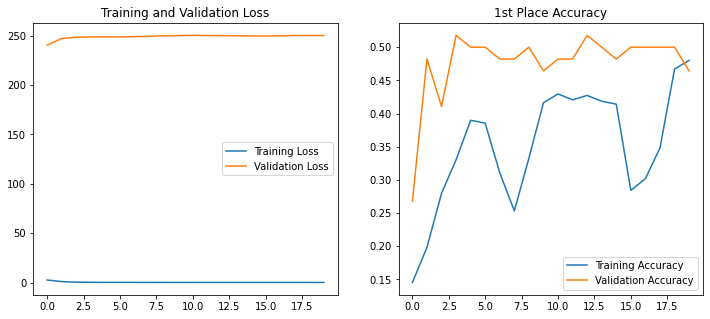

In [233]:
# performance = train_model3(train_loader, test_loader, epochs=20, load=False, lr=0.001, viz=True, path=path)


Epoch 500/500 - Train Acc: 0.59 | Val Acc: 0.52: 100%|██████████| 500/500 [08:03<00:00, 16.12s/epoch]


Model saved


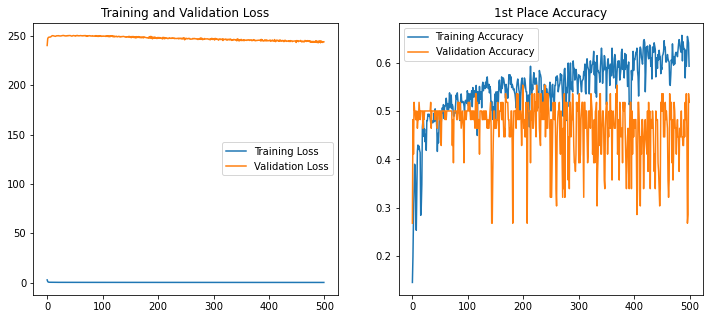

In [319]:
performance = train_model3(train_loader, test_loader, epochs=30, load=True, lr=0.001, viz=True, path=path)


# Model 4
Baseline model using 1 lap, and using spearman correlation as loss function

In [257]:
path = 'models/RaceMultiOutputModel4v1/'

# Load data
X_train = pd.read_csv('Data/RaceMultiOutPutModel/pos_1lap_X_train.csv')
y_train = pd.read_csv('Data/RaceMultiOutPutModel/Y_train.csv')
X_test = pd.read_csv('Data/RaceMultiOutPutModel/pos_1lap_X_test.csv')
y_test = pd.read_csv('Data/RaceMultiOutPutModel/Y_test.csv')

X_train.drop(['raceId'],axis=1, inplace=True)
y_train.drop(['raceId'],axis=1, inplace=True)
X_test.drop(['raceId'],axis=1, inplace=True)
y_test.drop(['raceId'],axis=1, inplace=True)


# Create Dataset and DataLoader for train and test sets
train_dataset = RaceDataset(torch.tensor(X_train.values, dtype=torch.float32), torch.tensor(y_train.values, dtype=torch.float32))
test_dataset = RaceDataset(torch.tensor(X_test.values, dtype=torch.float32), torch.tensor(y_test.values, dtype=torch.float32))

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Model 4 version 1
def train_model4(train_loader, test_loader, epochs=10, load=False, lr=0.001, viz=False, path=None):


    if not os.path.exists(path):
        os.makedirs(path)

    model = RaceMultiOutputModel4()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    if not load:
        prev_epoch = 0
        performance = pd.DataFrame()
        print('New model created')
    else:
        checkpoint = torch.load(f'{path}model.pt')
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        prev_epoch = checkpoint['epoch']
        performance = checkpoint['performance']

    first_epoch = prev_epoch + 1
    last_epoch = epochs + first_epoch - 1

    training_losses = []
    validation_losses = []

    train_fp_accs = []
    val_fp_accs = []

    with tqdm(total=last_epoch, initial=first_epoch-1, desc='Training Progress', unit='epoch') as epoch_pbar:
        for epoch in range(first_epoch, last_epoch + 1):
            # Training Phase
            model.train()
            train_loss = 0.0
            # first place prediction accuracy
            correct_first_place_predictions = 0
            total_races = 0

            for inputs, targets in train_loader:
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = spearman_rank_loss(outputs, targets)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()

                # Predicted and actual first-place finishers
                predicted_first_places = outputs.argmin(dim=1)
                actual_first_places = targets.argmin(dim=1)

                correct_first_place_predictions += (predicted_first_places == actual_first_places).sum().item()
                total_races += inputs.size(0)

            average_train_loss = train_loss / len(train_loader)
            training_losses.append(average_train_loss)
            train_outputs = outputs

            # Calculate the accuracy
            train_fp_acc = correct_first_place_predictions / total_races
            train_fp_accs.append(train_fp_acc)

            # Validation Phase
            model.eval()

            val_loss = 0.0

            # first place prediction accuracy
            correct_first_place_predictions = 0
            total_races = 0

            with torch.no_grad():
                for inputs, targets in test_loader:
                    outputs = model(inputs)
                    loss = criterion(outputs, targets)
                    val_loss += loss.item()

                    # Predicted and actual first-place finishers
                    predicted_first_places = outputs.argmin(dim=1)
                    actual_first_places = targets.argmin(dim=1)

                    correct_first_place_predictions += (predicted_first_places == actual_first_places).sum().item()
                    total_races += inputs.size(0)

                average_val_loss = val_loss / len(test_loader)
                validation_losses.append(average_val_loss)
                val_outputs = outputs

                # Calculate the accuracy
                val_fp_acc = correct_first_place_predictions / total_races
                val_fp_accs.append(val_fp_acc)
                
            epoch_pbar.set_description(f'Epoch {epoch}/{last_epoch} - Train Acc: {train_fp_acc:.2f} | Val Acc: {val_fp_acc:.2f}')
            epoch_pbar.update(1)

    performance = performance.append(pd.DataFrame({'epoch': list(range(first_epoch, last_epoch+1)), 'training_losses': training_losses, 'validation_losses': validation_losses, 'train_fp_acc': train_fp_accs, 'val_fp_acc': val_fp_accs}), ignore_index=True)


    if viz:
        visualize(performance, path, save=True)
    torch.save({
        'epoch': last_epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'performance': performance,
    }, f'{path}model.pt')
    print('Model saved')
    notify('Training Complete', path.split('/')[-1])
    return performance

In [258]:
performance = train_model4(train_loader, test_loader, epochs=50, load=False, lr=0.001, viz=True, path=path)


New model created


Training Progress:   0%|          | 0/50 [00:00<?, ?epoch/s]

Training Progress:   0%|          | 0/50 [00:00<?, ?epoch/s]


RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x240 and 24x128)

# Model 5
extreme baseline

In [266]:
path = 'models/RaceMultiOutputModel5v1/'

# Load data
X_train = pd.read_csv('Data/RaceMultiOutPutModel/pos_1lap_X_train.csv')
y_train = pd.read_csv('Data/RaceMultiOutPutModel/Y_train.csv')
X_test = pd.read_csv('Data/RaceMultiOutPutModel/pos_1lap_X_test.csv')
y_test = pd.read_csv('Data/RaceMultiOutPutModel/Y_test.csv')

X_train.drop(['raceId'],axis=1, inplace=True)
y_train.drop(['raceId'],axis=1, inplace=True)
X_test.drop(['raceId'],axis=1, inplace=True)
y_test.drop(['raceId'],axis=1, inplace=True)


# Create Dataset and DataLoader for train and test sets
train_dataset = RaceDataset(torch.tensor(X_train.values, dtype=torch.float32), torch.tensor(y_train.values, dtype=torch.float32))
test_dataset = RaceDataset(torch.tensor(X_test.values, dtype=torch.float32), torch.tensor(y_test.values, dtype=torch.float32))

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Model 5 version 1
def train_model5(train_loader, test_loader, epochs=10, load=False, lr=0.001, viz=False, path=None):


    if not os.path.exists(path):
        os.makedirs(path)

    model = RaceMultiOutputModel5()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    if not load:
        prev_epoch = 0
        performance = pd.DataFrame()
        print('New model created')
    else:
        checkpoint = torch.load(f'{path}model.pt')
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        prev_epoch = checkpoint['epoch']
        performance = checkpoint['performance']

    first_epoch = prev_epoch + 1
    last_epoch = epochs + first_epoch - 1

    training_losses = []
    validation_losses = []

    train_fp_accs = []
    val_fp_accs = []

    with tqdm(total=last_epoch, initial=first_epoch-1, desc='Training Progress', unit='epoch') as epoch_pbar:
        for epoch in range(first_epoch, last_epoch + 1):
            # Training Phase
            model.train()
            train_loss = 0.0
            # first place prediction accuracy
            correct_first_place_predictions = 0
            total_races = 0

            for inputs, targets in train_loader:
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = spearman_rank_loss(outputs, targets)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()

                # Predicted and actual first-place finishers
                predicted_first_places = outputs.argmin(dim=1)
                actual_first_places = targets.argmin(dim=1)

                correct_first_place_predictions += (predicted_first_places == actual_first_places).sum().item()
                total_races += inputs.size(0)

            average_train_loss = train_loss / len(train_loader)
            training_losses.append(average_train_loss)
            train_outputs = outputs

            # Calculate the accuracy
            train_fp_acc = correct_first_place_predictions / total_races
            train_fp_accs.append(train_fp_acc)

            # Validation Phase
            model.eval()

            val_loss = 0.0

            # first place prediction accuracy
            correct_first_place_predictions = 0
            total_races = 0

            with torch.no_grad():
                for inputs, targets in test_loader:
                    outputs = model(inputs)
                    loss = spearman_rank_loss(outputs, targets)
                    val_loss += loss.item()

                    # Predicted and actual first-place finishers
                    predicted_first_places = outputs.argmin(dim=1)
                    actual_first_places = targets.argmin(dim=1)

                    correct_first_place_predictions += (predicted_first_places == actual_first_places).sum().item()
                    total_races += inputs.size(0)

                average_val_loss = val_loss / len(test_loader)
                validation_losses.append(average_val_loss)
                val_outputs = outputs

                # Calculate the accuracy
                val_fp_acc = correct_first_place_predictions / total_races
                val_fp_accs.append(val_fp_acc)
                
            epoch_pbar.set_description(f'Epoch {epoch}/{last_epoch} - Train Acc: {train_fp_acc:.2f} | Val Acc: {val_fp_acc:.2f}')
            epoch_pbar.update(1)

    performance = performance.append(pd.DataFrame({'epoch': list(range(first_epoch, last_epoch+1)), 'training_losses': training_losses, 'validation_losses': validation_losses, 'train_fp_acc': train_fp_accs, 'val_fp_acc': val_fp_accs}), ignore_index=True)


    if viz:
        visualize(performance, path, save=True)
    torch.save({
        'epoch': last_epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'performance': performance,
    }, f'{path}model.pt')
    print('Model saved')
    notify('Training Complete', path.split('/')[-1])
    return performance

New model created


Epoch 2/10000 - Train Acc: 0.02 | Val Acc: 0.00:   0%|          | 1/10000 [00:00<03:09, 52.67epoch/s]

Epoch 10000/10000 - Train Acc: 0.14 | Val Acc: 0.23: 100%|██████████| 10000/10000 [01:31<00:00, 108.97epoch/s]


Model saved


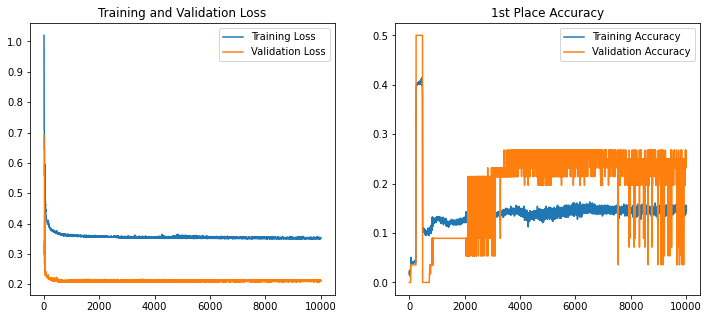

In [267]:
performance = train_model5(train_loader, test_loader, epochs=10000, load=False, lr=0.001, viz=True, path=path)


In [271]:
path = 'models/RaceMultiOutputModel5v2/'

# Load data
X_train = pd.read_csv('Data/RaceMultiOutPutModel/pos_1lap_X_train.csv')
y_train = pd.read_csv('Data/RaceMultiOutPutModel/Y_train.csv')
X_test = pd.read_csv('Data/RaceMultiOutPutModel/pos_1lap_X_test.csv')
y_test = pd.read_csv('Data/RaceMultiOutPutModel/Y_test.csv')

X_train.drop(['raceId'],axis=1, inplace=True)
y_train.drop(['raceId'],axis=1, inplace=True)
X_test.drop(['raceId'],axis=1, inplace=True)
y_test.drop(['raceId'],axis=1, inplace=True)


# Create Dataset and DataLoader for train and test sets
train_dataset = RaceDataset(torch.tensor(X_train.values, dtype=torch.float32), torch.tensor(y_train.values, dtype=torch.float32))
test_dataset = RaceDataset(torch.tensor(X_test.values, dtype=torch.float32), torch.tensor(y_test.values, dtype=torch.float32))

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Model 5 version 2
def train_model5v2(train_loader, test_loader, epochs=10, load=False, lr=0.001, viz=False, path=None):


    if not os.path.exists(path):
        os.makedirs(path)

    model = RaceMultiOutputModel5()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    if not load:
        prev_epoch = 0
        performance = pd.DataFrame()
        print('New model created')
    else:
        checkpoint = torch.load(f'{path}model.pt')
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        prev_epoch = checkpoint['epoch']
        performance = checkpoint['performance']

    first_epoch = prev_epoch + 1
    last_epoch = epochs + first_epoch - 1

    training_losses = []
    validation_losses = []

    train_fp_accs = []
    val_fp_accs = []

    with tqdm(total=last_epoch, initial=first_epoch-1, desc='Training Progress', unit='epoch') as epoch_pbar:
        for epoch in range(first_epoch, last_epoch + 1):
            # Training Phase
            model.train()
            train_loss = 0.0
            # first place prediction accuracy
            correct_first_place_predictions = 0
            total_races = 0

            for inputs, targets in train_loader:
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = weighted_ranking_loss(outputs, targets)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()

                # Predicted and actual first-place finishers
                predicted_first_places = outputs.argmin(dim=1)
                actual_first_places = targets.argmin(dim=1)

                correct_first_place_predictions += (predicted_first_places == actual_first_places).sum().item()
                total_races += inputs.size(0)

            average_train_loss = train_loss / len(train_loader)
            training_losses.append(average_train_loss)
            train_outputs = outputs

            # Calculate the accuracy
            train_fp_acc = correct_first_place_predictions / total_races
            train_fp_accs.append(train_fp_acc)

            # Validation Phase
            model.eval()

            val_loss = 0.0

            # first place prediction accuracy
            correct_first_place_predictions = 0
            total_races = 0

            with torch.no_grad():
                for inputs, targets in test_loader:
                    outputs = model(inputs)
                    loss = weighted_ranking_loss(outputs, targets)
                    val_loss += loss.item()

                    # Predicted and actual first-place finishers
                    predicted_first_places = outputs.argmin(dim=1)
                    actual_first_places = targets.argmin(dim=1)

                    correct_first_place_predictions += (predicted_first_places == actual_first_places).sum().item()
                    total_races += inputs.size(0)

                average_val_loss = val_loss / len(test_loader)
                validation_losses.append(average_val_loss)
                val_outputs = outputs

                # Calculate the accuracy
                val_fp_acc = correct_first_place_predictions / total_races
                val_fp_accs.append(val_fp_acc)
                
            epoch_pbar.set_description(f'Epoch {epoch}/{last_epoch} - Train Acc: {train_fp_acc:.2f} | Val Acc: {val_fp_acc:.2f}')
            epoch_pbar.update(1)

    performance = performance.append(pd.DataFrame({'epoch': list(range(first_epoch, last_epoch+1)), 'training_losses': training_losses, 'validation_losses': validation_losses, 'train_fp_acc': train_fp_accs, 'val_fp_acc': val_fp_accs}), ignore_index=True)


    if viz:
        visualize(performance, path, save=True)
    torch.save({
        'epoch': last_epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'performance': performance,
    }, f'{path}model.pt')
    print('Model saved')
    notify('Training Complete', path.split('/')[-1])
    return performance

New model created


Epoch 10/10 - Train Acc: 0.23 | Val Acc: 0.39: 100%|██████████| 10/10 [02:49<00:00, 16.92s/epoch]


Model saved


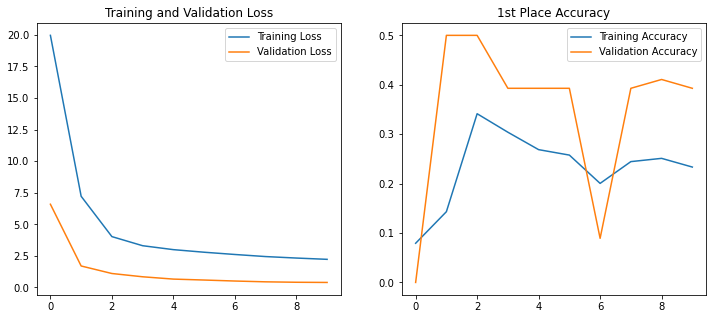

In [273]:
performance = train_model5v2(train_loader, test_loader, epochs=10, load=False, lr=0.001, viz=True, path=path)


In [282]:
path = 'models/RaceMultiOutputModel5v3/'

# Load data
X_train = pd.read_csv('Data/RaceMultiOutPutModel/pos_1lap_X_train.csv')
y_train = pd.read_csv('Data/RaceMultiOutPutModel/Y_train.csv')
X_test = pd.read_csv('Data/RaceMultiOutPutModel/pos_1lap_X_test.csv')
y_test = pd.read_csv('Data/RaceMultiOutPutModel/Y_test.csv')

X_train.drop(['raceId'],axis=1, inplace=True)
y_train.drop(['raceId'],axis=1, inplace=True)
X_test.drop(['raceId'],axis=1, inplace=True)
y_test.drop(['raceId'],axis=1, inplace=True)


# Create Dataset and DataLoader for train and test sets
train_dataset = RaceDataset(torch.tensor(X_train.values, dtype=torch.float32), torch.tensor(y_train.values, dtype=torch.float32))
test_dataset = RaceDataset(torch.tensor(X_test.values, dtype=torch.float32), torch.tensor(y_test.values, dtype=torch.float32))

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Model 5 version 3
def train_model5v3(train_loader, test_loader, epochs=10, load=False, lr=0.001, viz=False, path=None):


    if not os.path.exists(path):
        os.makedirs(path)

    model = RaceMultiOutputModel5()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    if not load:
        prev_epoch = 0
        performance = pd.DataFrame()
        print('New model created')
    else:
        checkpoint = torch.load(f'{path}model.pt')
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        prev_epoch = checkpoint['epoch']
        performance = checkpoint['performance']

    first_epoch = prev_epoch + 1
    last_epoch = epochs + first_epoch - 1

    training_losses = []
    validation_losses = []

    train_fp_accs = []
    val_fp_accs = []

    with tqdm(total=last_epoch, initial=first_epoch-1, desc='Training Progress', unit='epoch') as epoch_pbar:
        for epoch in range(first_epoch, last_epoch + 1):
            # Training Phase
            model.train()
            train_loss = 0.0
            # first place prediction accuracy
            correct_first_place_predictions = 0
            total_races = 0

            for inputs, targets in train_loader:
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()

                # Predicted and actual first-place finishers
                predicted_first_places = outputs.argmin(dim=1)
                actual_first_places = targets.argmin(dim=1)

                correct_first_place_predictions += (predicted_first_places == actual_first_places).sum().item()
                total_races += inputs.size(0)

            average_train_loss = train_loss / len(train_loader)
            training_losses.append(average_train_loss)
            train_outputs = outputs

            # Calculate the accuracy
            train_fp_acc = correct_first_place_predictions / total_races
            train_fp_accs.append(train_fp_acc)

            # Validation Phase
            model.eval()

            val_loss = 0.0

            # first place prediction accuracy
            correct_first_place_predictions = 0
            total_races = 0

            with torch.no_grad():
                for inputs, targets in test_loader:
                    outputs = model(inputs)
                    loss = criterion(outputs, targets)
                    val_loss += loss.item()

                    # Predicted and actual first-place finishers
                    predicted_first_places = outputs.argmin(dim=1)
                    actual_first_places = targets.argmin(dim=1)

                    correct_first_place_predictions += (predicted_first_places == actual_first_places).sum().item()
                    total_races += inputs.size(0)

                average_val_loss = val_loss / len(test_loader)
                validation_losses.append(average_val_loss)
                val_outputs = outputs

                # Calculate the accuracy
                val_fp_acc = correct_first_place_predictions / total_races
                val_fp_accs.append(val_fp_acc)
                
            epoch_pbar.set_description(f'Epoch {epoch}/{last_epoch} - Train Acc: {train_fp_acc:.2f} | Val Acc: {val_fp_acc:.2f}')
            epoch_pbar.update(1)

    performance = performance.append(pd.DataFrame({'epoch': list(range(first_epoch, last_epoch+1)), 'training_losses': training_losses, 'validation_losses': validation_losses, 'train_fp_acc': train_fp_accs, 'val_fp_acc': val_fp_accs}), ignore_index=True)


    if viz:
        visualize(performance, path, save=True)
    torch.save({
        'epoch': last_epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'performance': performance,
    }, f'{path}model.pt')
    print('Model saved')
    notify('Training Complete', path.split('/')[-1])
    return performance

Epoch 1502/3000 - Train Acc: 0.39 | Val Acc: 0.50:  50%|█████     | 1501/3000 [00:00<00:21, 68.30epoch/s]

Epoch 3000/3000 - Train Acc: 0.40 | Val Acc: 0.50: 100%|██████████| 3000/3000 [00:10<00:00, 139.46epoch/s]


Model saved


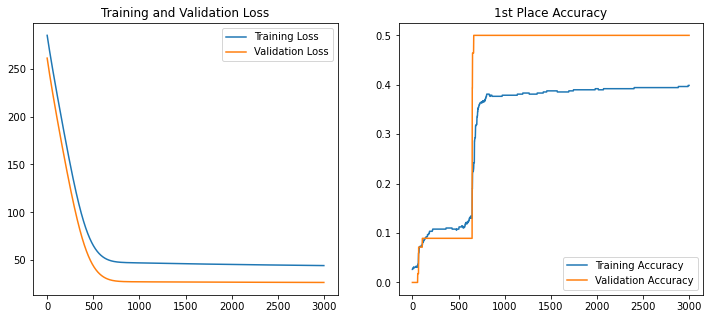

In [312]:
performance = train_model5v3(train_loader, test_loader, epochs=1500, load=True, lr=0.00001, viz=True, path=path)


In [294]:
path = path
model = RaceMultiOutputModel5()
criterion = nn.MSELoss()

checkpoint = torch.load(f'{path}model.pt')
model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# prev_epoch = checkpoint['epoch']
# performance = checkpoint['performance']




<All keys matched successfully>

In [295]:
model.eval()

RaceMultiOutputModel5(
  (fc1): Linear(in_features=24, out_features=24, bias=True)
  (fc2): Linear(in_features=24, out_features=24, bias=True)
)

In [288]:
with torch.no_grad():
    for inputs, targets in test_loader:
         outputs = model(inputs)

In [302]:
criterion(outputs[0,], targets[0,])

tensor(24.4315)

In [306]:
outputs[0,].argmin()
targets[0,].argmin()
(outputs[0,].argmin() == targets[0,].argmin()).sum().item()

0

In [307]:
targets[0,].numpy()

array([ 2.,  1.,  6.,  3., 17.,  4.,  7., 25., 10.,  8., 11., 12., 13.,
       15.,  9., 14., 18., 16.,  5., 25., 25., 25., 25., 25.],
      dtype=float32)

## model 5 v4

In [321]:
path = 'models/RaceMultiOutputModel5v4/'

# Load data
X_train = pd.read_csv('Data/RaceMultiOutPutModel/pos_1lap_X_train.csv')
y_train = pd.read_csv('Data/RaceMultiOutPutModel/Y_train.csv')
X_test = pd.read_csv('Data/RaceMultiOutPutModel/pos_1lap_X_test.csv')
y_test = pd.read_csv('Data/RaceMultiOutPutModel/Y_test.csv')

X_train.drop(['raceId'],axis=1, inplace=True)
y_train.drop(['raceId'],axis=1, inplace=True)
X_test.drop(['raceId'],axis=1, inplace=True)
y_test.drop(['raceId'],axis=1, inplace=True)


# Create Dataset and DataLoader for train and test sets
train_dataset = RaceDataset(torch.tensor(X_train.values, dtype=torch.float32), torch.tensor(y_train.values, dtype=torch.float32))
test_dataset = RaceDataset(torch.tensor(X_test.values, dtype=torch.float32), torch.tensor(y_test.values, dtype=torch.float32))

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Model 5 version 4
def train_model5v4(train_loader, test_loader, epochs=10, load=False, lr=0.001, viz=False, path=None):


    if not os.path.exists(path):
        os.makedirs(path)

    model = RaceMultiOutputModel5()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    if not load:
        prev_epoch = 0
        performance = pd.DataFrame()
        print('New model created')
    else:
        checkpoint = torch.load(f'{path}model.pt')
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        prev_epoch = checkpoint['epoch']
        performance = checkpoint['performance']

    first_epoch = prev_epoch + 1
    last_epoch = epochs + first_epoch - 1

    training_losses = []
    validation_losses = []

    train_fp_accs = []
    val_fp_accs = []

    with tqdm(total=last_epoch, initial=first_epoch-1, desc='Training Progress', unit='epoch') as epoch_pbar:
        for epoch in range(first_epoch, last_epoch + 1):
            # Training Phase
            model.train()
            train_loss = 0.0
            # first place prediction accuracy
            correct_first_place_predictions = 0
            total_races = 0

            for inputs, targets in train_loader:
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()

                # Predicted and actual first-place finishers
                predicted_first_places = outputs.argmin(dim=1)
                actual_first_places = targets.argmin(dim=1)

                correct_first_place_predictions += (predicted_first_places == actual_first_places).sum().item()
                total_races += inputs.size(0)

            average_train_loss = train_loss / len(train_loader)
            training_losses.append(average_train_loss)
            train_outputs = outputs

            # Calculate the accuracy
            train_fp_acc = correct_first_place_predictions / total_races
            train_fp_accs.append(train_fp_acc)

            # Validation Phase
            model.eval()

            val_loss = 0.0

            # first place prediction accuracy
            correct_first_place_predictions = 0
            total_races = 0

            with torch.no_grad():
                for inputs, targets in test_loader:
                    outputs = model(inputs)
                    loss = criterion(outputs, targets)
                    val_loss += loss.item()

                    # Predicted and actual first-place finishers
                    predicted_first_places = outputs.argmin(dim=1)
                    actual_first_places = targets.argmin(dim=1)

                    correct_first_place_predictions += (predicted_first_places == actual_first_places).sum().item()
                    total_races += inputs.size(0)

                average_val_loss = val_loss / len(test_loader)
                validation_losses.append(average_val_loss)
                val_outputs = outputs

                # Calculate the accuracy
                val_fp_acc = correct_first_place_predictions / total_races
                val_fp_accs.append(val_fp_acc)
                
            epoch_pbar.set_description(f'Epoch {epoch}/{last_epoch} - Train Acc: {train_fp_acc:.2f} | Val Acc: {val_fp_acc:.2f}')
            epoch_pbar.update(1)

    performance = performance.append(pd.DataFrame({'epoch': list(range(first_epoch, last_epoch+1)), 'training_losses': training_losses, 'validation_losses': validation_losses, 'train_fp_acc': train_fp_accs, 'val_fp_acc': val_fp_accs}), ignore_index=True)


    if viz:
        visualize(performance, path, save=True)
    torch.save({
        'epoch': last_epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'performance': performance,
    }, f'{path}model.pt')
    print('Model saved')
    notify('Training Complete', path.split('/')[-1])
    return performance

Training Progress:  90%|█████████ | 18000/20000 [00:00<?, ?epoch/s]

Epoch 20000/20000 - Train Acc: 0.43 | Val Acc: 0.50: 100%|██████████| 20000/20000 [00:14<00:00, 137.37epoch/s]


Model saved


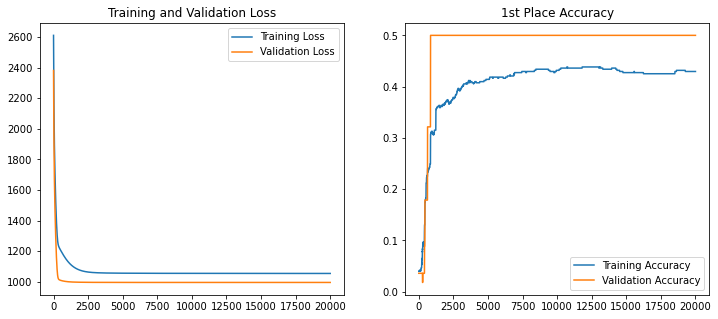

In [332]:
performance = train_model5v4(train_loader, test_loader, epochs=2000, load=True, lr=0.00001, viz=True, path=path)
